# Calorimeter regression task

In this project you will be looking at image like data from particle hits in a calorimeter. The goal of the project is to predict the location of the particle in the sky, using the data recorded by the calorimeter. Look in the `README.md` for more information.

First download the data, and then un-zip the data with `tar -zxvf data.tar.gz` into a data folder.
1. You can then use the functions within `utils.py` to load the data
2. We run `get_input_data` below to load in the images 

You may need to edit the `get_input_data` function in `utils.py` to have the right path.

## The training data
Here you get calorimeter images, as well as some additional information about the calorimeter.
The calorimeter data has the total energy of the corresponding image in the first column, and the calorimeter energy of the maximum bar.

## The target data
The target here is a vector of length four, where the first two columns are the x coordinates at the bottom and top, and then the y positions at the top and the bottom. To simplify the task, you can try predicting each layer individually, before attempting both layers together.
Top and bottom is relative to the tracker in the detector at -40mm and -200mm in z.


In [1]:
import os 
from utils import get_input_data
import numpy as np 
import helpers
import plotter 
from helpers import split_xy_intercept, get_data_dict, sort_data_by_energy, split_dico
from plotter import plot_image, plot_model_history
import matplotlib.pyplot as plt

# ML tools 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input, losses

from dampe_ai import split_train_val_test

import pdb

2024-05-30 16:50:47.150950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 16:50:47.200181: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-30 16:50:47.201468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 16:50:47.985073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [66]:
# Usefull flags
load_models = False
save_models = False

Load all the data

In [3]:
calorimeter_images, calorimeter_data, data_target, benchmark_data = get_input_data()

In [4]:
# Normalize the data 
calorimeter_images = calorimeter_images / 255.0
# calorimeter_images = calorimeter_images.reshape(calorimeter_images.shape[:3])/ 255.0

#### Data structure:

`calorimeter_images`: Calorimeter images

`calorimeter_data`: Calorimeter 2 variables  - bgoene (CALO total energy), maxbar (CALO energy of maximum bar)

`data_target`: Truth/target 4 variables - normally variables that are targeted at the regression optimisation,
say x_bot, x_top, y_bot, y_top

`benchmark_data`: Benchmark predictions 4 variables - Obtained from the standard BGO rec direction, x_bot, x_top, y_bot, y_top 

In [5]:
print(f"Input images of shape: {calorimeter_images.shape}255. and type {type(calorimeter_images)}")
print(f"Input data of shape: {calorimeter_data.shape} and type {type(calorimeter_data)}")
print(f"Target data of shape: {data_target.shape} and type {type(data_target)}")
print(f"Benchmark data of shape: {benchmark_data.shape} and type {type(benchmark_data)}")

Input images of shape: (141946, 14, 22, 1)255. and type <class 'numpy.ndarray'>
Input data of shape: (141946, 2) and type <class 'numpy.ndarray'>
Target data of shape: (141946, 4) and type <class 'numpy.ndarray'>
Benchmark data of shape: (141946, 4) and type <class 'numpy.ndarray'>


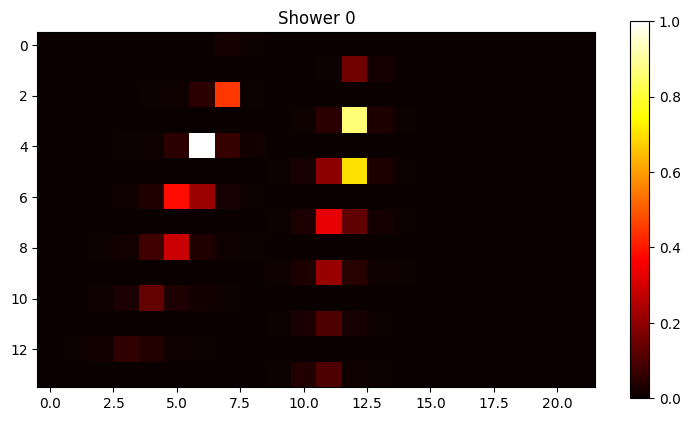

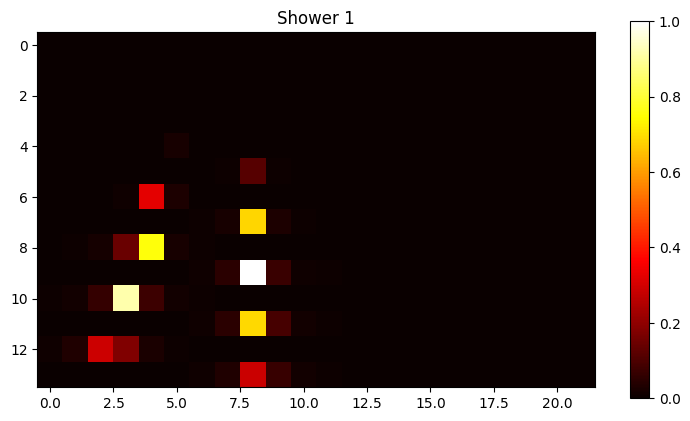

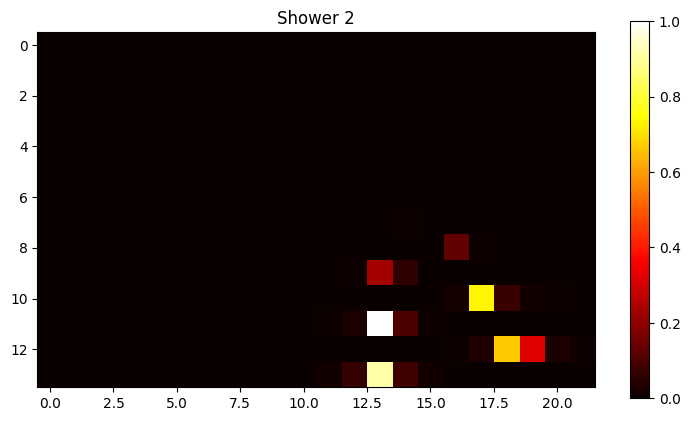

In [6]:
%matplotlib inline
#fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
for i in range(3):
    plot_image(calorimeter_images[i], image_name = 'Shower {}'.format(i))

Here we can see the structure of the data in image format for the first three showers.

The total energy of the shower and the max energy of a bar are also shown.

Note that there seem to be two lines alternating every row - this is the x-z and y-z split of the calormiter alternating each layer!

**The exercises can be found in the `README.md`**


Question : Is it starting with the x intercept or with the y intercept? Is the first row the x intercept and the second the y intercept or is it reversed?

In [7]:
print(calorimeter_images.shape)
X, Y = split_xy_intercept(calorimeter_images)
print(X.shape)
print(Y.shape)

(141946, 14, 22, 1)
(141946, 7, 22, 1)
(141946, 7, 22, 1)


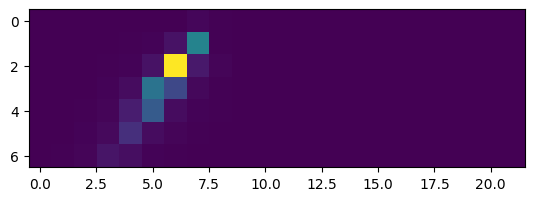

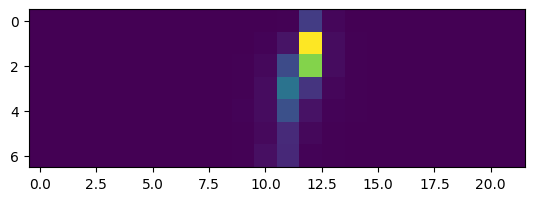

In [8]:
plt.imshow(X[0])
plt.show()
plt.imshow(Y[0])
plt.show()

Plot the image

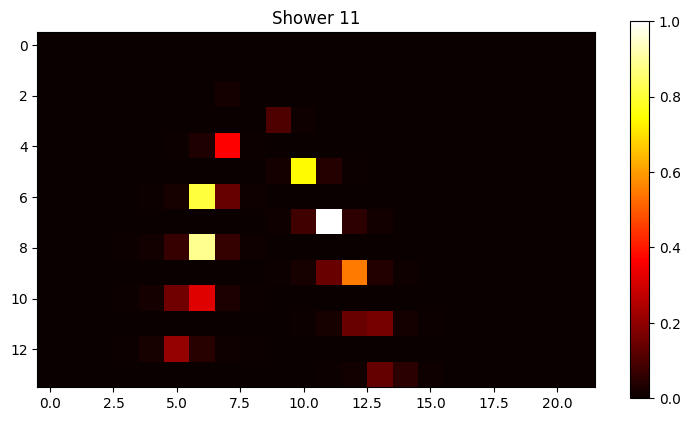

[18382280.   2695997.5]
[-173.23228  -106.88785   -33.886196  -64.71952 ]
[-173.8  -106.94  -38.3   -67.75]


In [9]:
shower_n = 11
plot_image(calorimeter_images[shower_n], image_name = 'Shower {}'.format(shower_n))

# Show the data first 
print(calorimeter_data[shower_n])
print(data_target[shower_n])
print(benchmark_data[shower_n])

Without further processing we directly apply a convolutional neural network for the regression task.

We start by spliting in 3 sets : \
Test  \
Train \
Validation

In [10]:
# Merge to shuffle
# Not used 
data_full = [ [ calorimeter_images[ii], data_target[ii] ] for ii in range( calorimeter_images.shape[0]) ]
# Shuffle 

In [11]:
# Normalize the data
# Split parameters
val_size  = 0.25
test_size = 0.35
dampe_dic = get_data_dict()

Im_train, Im_val, Im_test, xy_train, xy_val, xy_test = split_train_val_test(dampe_data = dampe_dic, val_size=val_size, test_size=test_size)

# Validation split 
#Im_train, Im_val, xy_train, xy_val = train_test_split(calorimeter_images, data_target, test_size = val_size)
# Test split
#Im_val , Im_test , xy_val , xy_test  = train_test_split(Im_val, xy_val, test_size = test_size)

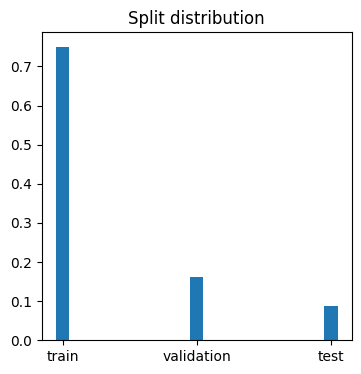

In [12]:
plt.figure(figsize=(4,4))
sample_size = data_target.shape[0]
try:
    plt.bar(['train', 'validation', 'test'],[xy_train.shape[0] / sample_size, xy_val.shape[0] / sample_size, xy_test.shape[0] / sample_size], width=0.1)
except: 
    plt.bar(['train', 'validation'],[xy_train.shape[0] / sample_size, xy_val.shape[0] / sample_size], width=0.1)
plt.title('Split distribution')
plt.show;

In [96]:
# Convolutional neural network 
if not load_models:
    model = models.Sequential()
    model.add(Input(shape=calorimeter_images[0].shape))
    model.add(layers.Conv2D(filters=52, kernel_size=(5, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=42, kernel_size=(5, 3), activation='relu'))
    model.add(layers.MaxPooling2D(1,2))
    model.add(layers.Conv2D(filters=32, kernel_size=(1, 4), activation='relu'))
    
    # Dense Feedforward neural network of the features 
    model.add(layers.Flatten())
    model.add(layers.Dense(units=64,activation='relu'))
    #model.add(layers.Dense(units=128,activation='relu'))
    model.add(layers.Dense(units=4,activation='linear'))
    
    
    ####
    model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 10, 20, 52)        832       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 5, 10, 52)         0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (None, 1, 8, 42)          32802     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 1, 4, 42)          0         
 ng2D)                                                           
                                                                 
 conv2d_119 (Conv2D)         (None, 1, 1, 32)          5408      
                                                                 
 flatten_39 (Flatten)        (None, 32)              

In [94]:
# Compile the model 
if not load_models:
    model.compile(
        optimizer='adam', 
        loss=losses.MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    history = model.fit(Im_train, xy_train, epochs=2, 
                        validation_data=(Im_val, xy_val))

Epoch 1/2
3327/3327 [==============================] - 19s 6ms/step - loss: 19801.9727 - mean_squared_error: 19801.9727 - mean_absolute_error: 114.0104 - val_loss: 17662.1445 - val_mean_squared_error: 17662.1445 - val_mean_absolute_error: 107.2355
Epoch 2/2
3327/3327 [==============================] - 17s 5ms/step - loss: 7511.4487 - mean_squared_error: 7511.4487 - mean_absolute_error: 61.3799 - val_loss: 1776.0956 - val_mean_squared_error: 1776.0956 - val_mean_absolute_error: 31.0155


In [82]:
# Convolutional neural network 
if not load_models:
    model2 = models.Sequential()
    model2.add(Input(shape=calorimeter_images[0].shape))
    model2.add(layers.Conv2D(filters=32, kernel_size=(5, 4), activation='relu'))
    model2.add(layers.Conv2D(filters=32, kernel_size=(5, 4), activation='relu'))
    model2.add(layers.Conv2D(filters=8, kernel_size=(6, 16), activation='relu'))
    
    # Dense Feedforward neural network of the features 
    model2.add(layers.Flatten())
    model2.add(layers.Dense(units=64,activation='relu'))
    #model.add(layers.Dense(units=128,activation='relu'))
    model2.add(layers.Dense(units=4,activation='linear'))
    
    
    ####
    model2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 10, 19, 8)         168       
                                                                 
 conv2d_86 (Conv2D)          (None, 6, 16, 12)         1932      
                                                                 
 conv2d_87 (Conv2D)          (None, 1, 1, 32)          36896     
                                                                 
 flatten_28 (Flatten)        (None, 32)                0         
                                                                 
 dense_58 (Dense)            (None, 64)                2112      
                                                                 
 dense_59 (Dense)            (None, 4)                 260       
                                                                 
Total params: 41368 (161.59 KB)
Trainable params: 413

In [83]:
# Compile the model 
if not load_models:
    model2.compile(
        optimizer='adam', 
        loss=losses.MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
    history = model2.fit(Im_train, xy_train, epochs=2, 
                        validation_data=(Im_test, xy_test))

Epoch 1/2
3327/3327 [==============================] - 18s 5ms/step - loss: 8729.8398 - mean_squared_error: 8729.8398 - mean_absolute_error: 64.0404 - val_loss: 1582.7883 - val_mean_squared_error: 1582.7883 - val_mean_absolute_error: 28.2747
Epoch 2/2
3327/3327 [==============================] - 16s 5ms/step - loss: 985.0512 - mean_squared_error: 985.0512 - mean_absolute_error: 22.2526 - val_loss: 698.2019 - val_mean_squared_error: 698.2019 - val_mean_absolute_error: 18.8963


In [17]:
# Save the model 
if save_models:
    tf_models_dir = os.path.join(os.getcwd(),'tfModel')
    if not os.path.isdir(tf_models_dir):
        os.mkdir(tf_models_dir)
    model2.save(os.path.join(tf_models_dir,'model2.keras'), overwrite=True)
    # Save the fitting history to json
    helpers.save_model_history(history, 'model2')

In [18]:
# Load the model 
if load_models:
    model   = keras.saving.load_model('./tfModel/model2.keras')
    history = helpers.load_model_history('./models/model2.json')

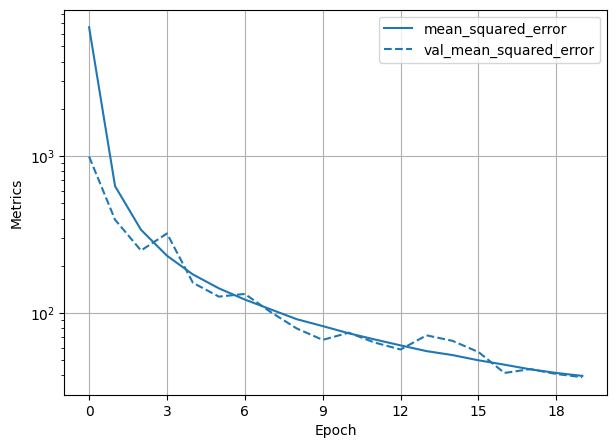

In [19]:
plot_model_history(history,loglevel=True,savefig=False);

In [20]:
# Predict from the validation 
xy_prediction = model.predict(Im_val)

721/721 [==============================] - 2s 2ms/step


Separate the energy levels

In [21]:
dampe_dic = get_data_dict()

In [22]:
tmp, tmp_idx = sort_data_by_energy('total')

In [23]:
dico_list = split_dico(tmp, frac=[0.5, 0.5])

Build the splited model 

In [63]:
model_low = models.Sequential()
model_low.add(Input(shape=calorimeter_images[0].shape))
model_low.add(layers.Conv2D(filters=8, kernel_size=(5, 4), activation='relu'))
model_low.add(layers.Conv2D(filters=16, kernel_size=(5, 4), activation='relu'))
model_low.add(layers.Conv2D(filters=16, kernel_size=(6, 16), activation='relu'))

# Dense Feedforward neural network of the features 
model_low.add(layers.Flatten())
model_low.add(layers.Dense(units=64,activation='relu'))
#model_low.add(layers.Dense(units=64,activation='relu'))
model_low.add(layers.Dense(units=4,activation='linear'))

# Copy for high energy
model_high = keras.models.clone_model(model_low)

####
model_high.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 10, 19, 8)         168       
                                                                 
 conv2d_46 (Conv2D)          (None, 6, 16, 16)         2576      
                                                                 
 conv2d_47 (Conv2D)          (None, 1, 1, 16)          24592     
                                                                 
 flatten_15 (Flatten)        (None, 16)                0         
                                                                 
 dense_32 (Dense)            (None, 64)                1088      
                                                                 
 dense_33 (Dense)            (None, 4)                 260       
                                                                 
Total params: 28684 (112.05 KB)
Trainable params: 286

In [61]:
# Split the data in train, validation and test
Im_train_low , Im_val_low , Im_test_low , xy_train_low , xy_val_low , xy_test_low  = split_train_val_test(dico_list[0], val_size = 0.2, test_size = 0.4)
Im_train_high, Im_val_high, Im_test_high, xy_train_high, xy_val_high, xy_test_high = split_train_val_test(dico_list[1], val_size = 0.2, test_size = 0.4)

In [62]:
# Compile the models
model_low.compile(
        optimizer='adam', 
        loss=losses.MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
history = model_low.fit(Im_train_low, xy_train_low, epochs=2, 
                     validation_data=(Im_val_low, xy_val_low))

Epoch 1/2
1775/1775 [==============================] - 10s 5ms/step - loss: 16579.5684 - mean_squared_error: 16579.5684 - mean_absolute_error: 99.5250 - val_loss: 5033.0449 - val_mean_squared_error: 5033.0449 - val_mean_absolute_error: 53.7827
Epoch 2/2
1775/1775 [==============================] - 8s 5ms/step - loss: 2831.2161 - mean_squared_error: 2831.2161 - mean_absolute_error: 38.9693 - val_loss: 1680.5024 - val_mean_squared_error: 1680.5024 - val_mean_absolute_error: 30.2784


In [65]:
# Compile the models
model_high.compile(
        optimizer='adam', 
        loss=losses.MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
    )
    
history = model_high.fit(Im_train_high, xy_train_high, epochs=2, 
                     validation_data=(Im_val_high, xy_val_high))

Epoch 1/2
1775/1775 [==============================] - 9s 5ms/step - loss: 1214.5504 - mean_squared_error: 1214.5504 - mean_absolute_error: 24.7171 - val_loss: 724.2293 - val_mean_squared_error: 724.2293 - val_mean_absolute_error: 18.9768
Epoch 2/2
1775/1775 [==============================] - 9s 5ms/step - loss: 596.3312 - mean_squared_error: 596.3312 - mean_absolute_error: 17.3174 - val_loss: 607.2040 - val_mean_squared_error: 607.2040 - val_mean_absolute_error: 17.9754
